In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.python.client import device_lib
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0, 1"
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
print(gpus, cpus)
# 设置当前程序的可见设备范围
tf.config.experimental.set_visible_devices(devices=gpus, device_type='GPU')

# 设置仅在需要时申请：
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
# 下面的方式是设置Tensorflow固定消耗GPU:0的2GB显存
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=200)]
)

def get_available_gpus():
  local_device_protos = device_lib.list_local_devices()
  return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

2.0.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')] [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
['/device:GPU:0', '/device:GPU:1']


In [92]:
with tf.device('/device:GPU:0'):
    w = tf.constant([[2, -3.4]])
    b = tf.constant([4.2])
    x = tf.random.normal([1000, 2], mean=0, stddev=10)
    e = tf.random.normal([1000, 2], mean=0, stddev=0.1)
    W = tf.Variable(tf.constant([5, 1]))
    B = tf.Variable(tf.constant([1]))
w

<tf.Tensor: id=710889, shape=(1, 2), dtype=float32, numpy=array([[ 2. , -3.4]], dtype=float32)>

In [93]:
import random
from matplotlib import pyplot as plt
# 线性回归模型， y = 
# 生成数据,生成1000组数据

num_inputs = 2
num_examples = 1000
true_y = tf.matmul(x, tf.transpose(w)) + b
x, true_y
# 读取数据

(<tf.Tensor: id=710896, shape=(1000, 2), dtype=float32, numpy=
 array([[11.904217 , 10.821163 ],
        [ 3.4219682, -3.1656156],
        [-4.010166 ,  1.2370993],
        ...,
        [-7.40069  ,  5.107273 ],
        [ 4.918063 ,  1.1951212],
        [ 6.251775 ,  9.301053 ]], dtype=float32)>,
 <tf.Tensor: id=710920, shape=(1000, 1), dtype=float32, numpy=
 array([[-8.78352070e+00],
        [ 2.18070297e+01],
        [-8.02647018e+00],
        [-5.05666256e-01],
        [-6.48605270e+01],
        [ 9.50017929e+00],
        [ 1.44045305e+01],
        [ 2.50916481e+01],
        [-1.00638485e+00],
        [ 6.16355553e+01],
        [-1.07517786e+01],
        [ 6.02755737e+00],
        [ 4.86500206e+01],
        [-1.33696604e+01],
        [ 1.03340054e+00],
        [ 3.43312225e+01],
        [ 2.38971443e+01],
        [-3.98574257e+01],
        [ 5.11106415e+01],
        [-4.44288731e+00],
        [-2.60181007e+01],
        [-5.44732361e+01],
        [-2.24977150e+01],
        [-2.402527

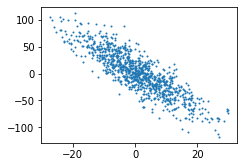

In [94]:
def set_figsize(figsize=(3.5, 2.5)):
    plt.rcParams['figure.figsize'] = figsize

set_figsize()

plt.scatter(x[: ,1], true_y, 1)

In [95]:
def data_scale(x, y):
    return x, y

db = tf.data.Dataset.from_tensor_slices((x, true_y))
db_all = db.map(data_scale)
# 为了每个epchoes都打散，可以把下面　db　放到每轮内部去shuffle和ｂａｔｃｈ
# db = db_all.shuffle(10)
# db_batch = db.batch(32)
# 查看一组数据
# print(next(iter(db_batch)))

In [96]:
# 构建模型（此处就不需要自己定义变量在进行矩阵计算了，直接调用包就好了）
# 导入模块
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import initializers as init

# 使用Sequential模式创建
model = keras.Sequential()
model.add(layers.Dense(1, kernel_initializer=init.RandomNormal(stddev=0.01)))

In [97]:
# 定义损失函数
from tensorflow import losses

#均方损失 
loss = losses.MeanSquaredError()

In [98]:
# 定义优化算法
from tensorflow.keras import optimizers
trainer = optimizers.SGD(learning_rate=0.001)

在使用Tensorflow训练模型时，我们通过调用tensorflow.GradientTape记录动态图梯度，执行tape.gradient获得动态图中各变量梯度。通过 model.trainable_variables 找到需要更新的变量，并用 trainer.apply_gradients 更新权重，完成一步训练。

In [99]:
# 训练模型

num_epoches = 3
for epoch in range(num_epoches):
    batch_data = db_all.shuffle(10)
    batch_data = batch_data.batch(32)
    for n, (train_x, train_y) in enumerate(batch_data):
#         print(x, y)
        print('x.shape', x.shape)
        with tf.GradientTape() as tape:
            l = loss(model(train_x), train_y)
        # 自动记录可训练变量
        grads = tape.gradient(l, model.trainable_variables)
        # 完成梯度更新
        trainer.apply_gradients(zip(grads, model.trainable_variables))
        # model.trainable_variables查看模型参数
        print(n , '\n', model.trainable_variables[0])
        # 通过 model.get_weights()[0]查看相关权重
        print(model.get_weights())
    # 每轮求一次全部的平均损失
    l = loss(model(x), true_y)
    print('\n epoch %d , loss: %f' % (epoch, l.numpy()))

x.shape (1000, 2)
0 
 <tf.Variable 'sequential_8/dense_7/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[ 0.17276232],
       [-0.46700823]], dtype=float32)>
[array([[ 0.17276232],
       [-0.46700823]], dtype=float32), array([0.0116694], dtype=float32)]
x.shape (1000, 2)
1 
 <tf.Variable 'sequential_8/dense_7/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[ 0.6112487],
       [-0.8874874]], dtype=float32)>
[array([[ 0.6112487],
       [-0.8874874]], dtype=float32), array([-0.0001864], dtype=float32)]
x.shape (1000, 2)
2 
 <tf.Variable 'sequential_8/dense_7/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.0133995],
       [-1.6656827]], dtype=float32)>
[array([[ 1.0133995],
       [-1.6656827]], dtype=float32), array([0.0126952], dtype=float32)]
x.shape (1000, 2)
3 
 <tf.Variable 'sequential_8/dense_7/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.056464 ],
       [-2.1160405]], dtype=float32)>
[array([[ 1.056464 ],
       [-2.1160405]], dtype=float32), array(

x.shape (1000, 2)
10 
 <tf.Variable 'sequential_8/dense_7/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.9969782],
       [-3.3833625]], dtype=float32)>
[array([[ 1.9969782],
       [-3.3833625]], dtype=float32), array([0.32186714], dtype=float32)]
x.shape (1000, 2)
11 
 <tf.Variable 'sequential_8/dense_7/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.9873252],
       [-3.3840227]], dtype=float32)>
[array([[ 1.9873252],
       [-3.3840227]], dtype=float32), array([0.32960436], dtype=float32)]
x.shape (1000, 2)
12 
 <tf.Variable 'sequential_8/dense_7/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.9867048],
       [-3.3928826]], dtype=float32)>
[array([[ 1.9867048],
       [-3.3928826]], dtype=float32), array([0.33735818], dtype=float32)]
x.shape (1000, 2)
13 
 <tf.Variable 'sequential_8/dense_7/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.9895765],
       [-3.3807497]], dtype=float32)>
[array([[ 1.9895765],
       [-3.3807497]], dtype=float32), arra

[array([[ 2.005389 ],
       [-3.3928077]], dtype=float32), array([0.66952103], dtype=float32)]
x.shape (1000, 2)
26 
 <tf.Variable 'sequential_8/dense_7/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[ 2.0093486],
       [-3.407454 ]], dtype=float32)>
[array([[ 2.0093486],
       [-3.407454 ]], dtype=float32), array([0.6766004], dtype=float32)]
x.shape (1000, 2)
27 
 <tf.Variable 'sequential_8/dense_7/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.9952488],
       [-3.396721 ]], dtype=float32)>
[array([[ 1.9952488],
       [-3.396721 ]], dtype=float32), array([0.68369305], dtype=float32)]
x.shape (1000, 2)
28 
 <tf.Variable 'sequential_8/dense_7/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[ 2.0071065],
       [-3.3840978]], dtype=float32)>
[array([[ 2.0071065],
       [-3.3840978]], dtype=float32), array([0.6907282], dtype=float32)]
x.shape (1000, 2)
29 
 <tf.Variable 'sequential_8/dense_7/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[ 2.0014942],
       [

## 总结：
１、创建模型：tf.kears.Sequential(), tf.keras.layer直接创建, 并且可以使用 tensorflow.initializers 进行参数初始化

２、损失函数：tf.losses.MSE(x, y) 等各种，直接进行矩阵计算，得到平均损失，等价于：tf.reduce_mean(tf.square(predicted_y - tf.reshape(desired_y, predicted_y.shape)))

３、优化算法（优化器）: tf.keras.optimizers.SGD(learning_rate=0.01)直接定义优化算法

４、训练模型: tape.gradient(l, model.trainable_variables) 记录动态图梯度, trainer.apply_gradients(zip(grads, model.trainable_variables)) 进行梯度自动更新

５、查看参数: model.trainable_variables 查看模型参数